# **淺度機器學習 作業4-1**
## **目標** : 利用PyTorch實作卷積神經網路，並在完整的了解其模型結構後以Yale Face Data進行訓練並嘗試辨識測試資料中人臉的Label。

---
* 410978049 統計三 江泓志
***

# Part1: 資料處理

## 載入需要的套件 :

In [2]:
from sklearn.model_selection import train_test_split # 拆分訓練測試集
import matplotlib.pyplot as plt # 畫圖
from scipy.io import loadmat # 載入matlab檔案
from tqdm import tqdm # 進度條
import seaborn as sns # 畫圖輔助
import pandas as pd # 讀資料
import numpy as np # 使用ndarray及相關計算
import sys # 應用於螢幕輸出調整 (tqdm與print衝突問題)

# torch 系列
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torchvision

## 讀取 Yale Face Data:

* 這裡我們將Yale Face Data讀進來之後，抓取資料的Label並將資料的八成分成訓練集而剩下兩成為測試集，並且為了之後方便觀察模型訓練的表現，我們另外從訓練集中分出了1%，也就是20筆資料做為驗證集。

In [3]:
dirThis = 'C:\\vs_code_python\\data\\'
D = loadmat(dirThis + 'allFaces.mat')
data = D['faces'].T

face_y = np.ndarray.flatten(D['nfaces'])
m = int(D['m'])
n = int(D['n'])
idx = 0
tmp = 0
targett = np.empty(shape = data.shape[0])
for i, j in enumerate(face_y) :
    tmp = idx
    idx += j
    targett[tmp:idx] = i
target = pd.DataFrame(targett.astype(int), columns = ['target'])
 
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=test_size)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = 0.01)

* 接著我們將資料轉換成tensor形式以利使用GPU運算，並且為了讓資料是用人臉方向為正的方式訓練，我們先把資料轉成三維矩陣然後轉置圖像的那兩維，並攤平後才轉成tensor的資料型態。

In [4]:
# convert to tensors
X_train = torch.from_numpy(X_train.reshape(X_train.shape[0], m, n).transpose(0, 2, 1)).float() # (N, 168, 192)[numpy] -> (N, 192, 168)[numpy] -> (N * 192, * 168, )[tensor]
y_train = torch.from_numpy(y_train.to_numpy().flatten()).long()
X_train = X_train.reshape(-1, 1, n, m) # convert to N x 1 x 192 x 168 for CNN

X_test = torch.from_numpy(X_test.reshape(X_test.shape[0], m, n).transpose(0, 2, 1)).float()
y_test = torch.from_numpy(y_test.to_numpy().flatten()).long()
X_test = X_test.reshape(-1, 1, n, m) # N x 1 x 192 x 168

X_valid = torch.from_numpy(X_valid.reshape(X_valid.shape[0], m, n).transpose(0, 2, 1)).float()
y_valid = torch.from_numpy(y_valid.to_numpy().flatten()).long()
X_valid = X_valid.reshape(-1, 1, n, m)
 
# check shapes of data
print("X_train.shape:", X_train.shape)
print("y_train.shape:", y_train.shape)
print("X_test.shape:", X_test.shape)
print("y_test.shape:", y_test.shape)
print("X_valid.shape:", X_valid.shape)
print("y_valid.shape:", y_valid.shape)
 
# create dataloaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
valid_dataset = TensorDataset(X_valid, y_valid)
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

X_train.shape: torch.Size([1908, 1, 192, 168])
y_train.shape: torch.Size([1908])
X_test.shape: torch.Size([482, 1, 192, 168])
y_test.shape: torch.Size([482])
X_valid.shape: torch.Size([20, 1, 192, 168])
y_valid.shape: torch.Size([20])


### 問題與討論 : 
    這裡我們認為標準化會丟失一些人臉特徵的訊息導致影響訓練，所以這邊不對資料做標準化。
    而我們也選取了較小的batch_size: 16個以利訓練的進行。

# 模型建立

* 這裡我們先建立一個基礎的CNN模型，其內包含兩個卷積層和兩個池化層以及三個全連階層。

In [6]:
class Net(nn.Module):
 
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 45 * 39, 120)  # conv windows: 16  X  image dimension: 45 * 39
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38) # 38 output classes
 
    def forward(self, x):
        # (192, 168)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # conv: (188, 164) -> pool: (94, 82)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # conv: (90, 78) -> pool: (45, 39)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
 
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
 
net = Net().to(device)
print(net)

Using cuda:0 device
Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28080, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
)


### 問題與討論 : 
    可以看到我們這裡成功使用了GPU作為運算裝置，而印出模型後模型看起來也沒有太大的問題。

* 接著我們檢查模型的輸入輸出是否正確。

In [9]:
input = train_dataset[0][0].reshape(1, 1, m, n)
# 觀察 network 輸出結果
out = net(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())

(1, 38)
tensor([[ 0.1768, -1.6164, -3.6764, -1.5450, -1.1889, -1.3924,  1.5498, -1.0308,
          2.3647, -0.9772, -4.9018,  1.0150, -1.8860, -2.4989, -0.8983,  1.1562,
         -0.4179, -2.3578, -1.8709, -0.0071,  1.3736,  1.9441, -1.1013,  2.9164,
         -0.5115, -1.0885, -0.7725, -0.7446,  0.7854,  1.5453,  1.5042,  2.4000,
          3.5596,  1.4063, -1.1847, -2.1008, -2.5405, -0.4943]],
       device='cuda:0')
tensor([[32]], device='cuda:0')
[[ 0.17676452 -1.616389   -3.6764429  -1.5449512  -1.1889172  -1.3923882
   1.5497956  -1.0308423   2.3646765  -0.97718245 -4.9017653   1.015008
  -1.8859786  -2.4989316  -0.8982543   1.1562191  -0.41788566 -2.357761
  -1.870899   -0.00705374  1.3736033   1.9441166  -1.101255    2.9164143
  -0.5115351  -1.0885253  -0.7724752  -0.74462295  0.785392    1.5452653
   1.5041869   2.4000018   3.5596426   1.406265   -1.1846546  -2.1008148
  -2.5404723  -0.49431238]]


### 問題與討論 : 
    如結果所示，是可以正常執行前饋運算的，模型建構應沒有問題。

* 接著我們隨機印出資料中的一張照片(創建train_loader時是有shuffle的，所以每次結果都不一樣)，並以一列8張圖片印出某一個batch的所有人臉圖片。

torch.Size([16, 1, 192, 168])


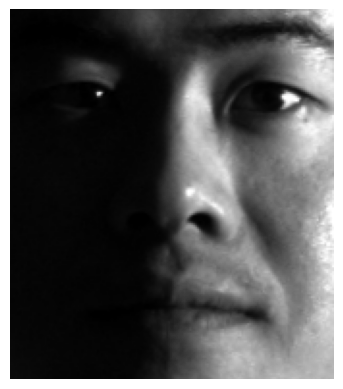

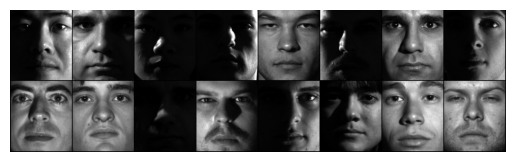

In [8]:
# get some random training images
dataiter = iter(train_loader) # an iterable object
images, labels = next(dataiter) # get the next batch
print(images.shape)
 
# show a single image
a_image = images[0]
a_image_ = np.transpose(a_image, (1, 2, 0))
plt.imshow(a_image_, cmap='gray')
plt.axis('off')
plt.show()
 
# show a grid of images
montage = torchvision.utils.make_grid(images/255, nrow=8) # make a grid of images with 16 images per row
plt.imshow(np.transpose(montage, (1, 2, 0)))
plt.axis('off')
plt.show()

### 問題與討論 : 
    如圖，可以看到我們的資料沒有什麼問題，但就像在作業3中提及的，每個人光線、明暗都不太一樣，對神經網路應該也會有一定的挑戰性。

# 訓練方法以及評估方式

## 訓練方法

* 這裡我們仿造本次作業的第二部分-SRCNN的寫法，另外寫一個train的函數。

In [20]:
def train(model, dataloader) :
    model.train()
    running_loss = 0.0
    for data in dataloader :
        image_data = data[0].to(device)
        label = data[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(image_data)
        loss = criterion(outputs, label)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    final_loss = running_loss/len(dataloader.dataset)
    return final_loss

### 問題與討論 : 
    這個函數在訓練一個epoch後，更新優化器並回傳當前的loss值。

## 評估方式

* 我們同樣仿造SRCNN的寫法，另外寫一個getLossAcc函數。

In [21]:
def getLossAcc(model, dataLoader) :
  model.eval()
  running_acc = 0.0
  running_loss = 0.0
  with torch.no_grad():
      for data in dataLoader :
          images, labels = data[0].to(device), data[1].to(device)
          outputs = model(images)

          loss = criterion(outputs, labels)
          running_loss += loss.item()

          _, predicted = torch.max(outputs.data, 1)
          running_acc += (predicted == labels).sum().item()
  return running_acc / len(dataLoader.dataset), running_loss / len(dataLoader.dataset)

### 問題與討論 : 
    這個函數回傳model在這組dataloader上的表現，分別有Accuracy和Loss值。

# 模型訓練

* 以下我們使用上面建構的CNN模型進行訓練，我們使用交叉熵做為損失函數 (因為我們的任務是人臉的類別Label辨認)，並選擇隨機梯度下降做為優化器 (但有設定momentum為0.9避免掉入區域最佳解)，而學習速率設為0.001，並訓練100個epochs。

^註1: 雖然學術界普遍認為Adam優化器可以收斂得更好更快，但不論是我自己的嘗試或是網路上的資訊似乎都表明PyTorch的Adam優化器實現是有問題的，很容易就會無法收斂，雖然調整學習速率有機會改善這個問題並讓Adam優化器正常運作，但我認為調整後表現仍沒有SGD來的好，所以這裡我們都將選擇SGD做為優化器。

^註2: 我們另外紀錄了訓練過程中訓練集和驗證集的Loss值和準確率，方便我們知道模型的表現。

In [ ]:
epochs = 100
model = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
trainLoss = []
trainAcc = []
validLoss = []
validAcc = []
for epoch in tqdm(range(epochs), position=0, file=sys.stdout, desc="desc") :

    running_loss = train(model, train_loader)

    trEpoch = getLossAcc(model, train_loader)
    vaEpoch = getLossAcc(model, valid_loader)

    trainAcc.append(trEpoch[0])
    trainLoss.append(trEpoch[1])
    validAcc.append(vaEpoch[0])
    validLoss.append(vaEpoch[1])

    if epoch%10 == 9 or epoch == 0 :
      tqdm.write(f'[epoch : {epoch + 1}] loss: {running_loss / 200:.8f} acc: {trEpoch[0]:.4f} valid_acc: {vaEpoch[0]:.4f}')

print('Finished Training')  

[epoch : 1] loss: 0.00080598 acc: 0.7568 valid_acc: 0.7500
[epoch : 10] loss: 0.00000453 acc: 0.9990 valid_acc: 0.8500
[epoch : 20] loss: 0.00001890 acc: 0.9885 valid_acc: 0.9000
[epoch : 30] loss: 0.00000258 acc: 1.0000 valid_acc: 0.8500
[epoch : 40] loss: 0.00000286 acc: 1.0000 valid_acc: 0.8500
[epoch : 50] loss: 0.00002480 acc: 0.9953 valid_acc: 0.8500
[epoch : 60] loss: 0.00000084 acc: 1.0000 valid_acc: 0.8000
[epoch : 70] loss: 0.00000022 acc: 1.0000 valid_acc: 0.8000
[epoch : 80] loss: 0.00000011 acc: 1.0000 valid_acc: 0.8000
[epoch : 90] loss: 0.00000007 acc: 1.0000 valid_acc: 0.8000
[epoch : 100] loss: 0.00000005 acc: 1.0000 valid_acc: 0.8000
desc: 100%|██████████| 100/100 [01:25<00:00,  1.17it/s]
Finished Training


### 問題與討論 : 
    我們觀察訓練過程中的train loss, train acc, valid(test) acc，可以看到模型中過擬合的問題應是相當嚴重的，訓練集的準確率很快就變成100%了，但測試集的準確率卻卡住上不去。

* 損失函數以及準確率圖: 這裡我們繪製訓練過程中Loss值和準確率的變化觀察訓練情況。

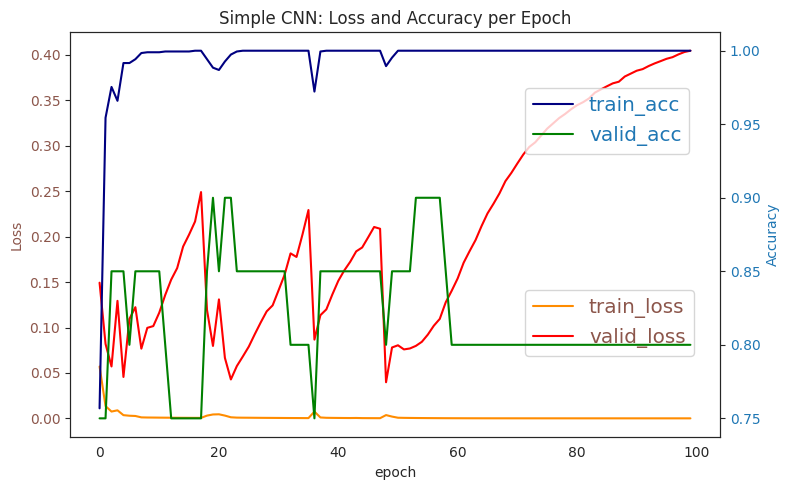

In [ ]:
def drawPlot(name, trainLoss, validLoss, trainAcc, validAcc) :
    sns.set_style('white')
    plt.rcParams['figure.figsize'] = [8, 5]
    fig, ax1 = plt.subplots()
    plt.title(name + ': Loss and Accuracy per Epoch')
    plt.xlabel('epoch')
    ax2 = ax1.twinx()

    ax1.set_ylabel('Loss', color = 'tab:brown')
    ax1.plot(trainLoss, color = 'darkorange')
    ax1.plot(validLoss, color = 'red')
    ax1.tick_params(axis = 'y', labelcolor = 'tab:brown')

    ax2.set_ylabel('Accuracy', color = 'tab:blue')
    ax2.plot(trainAcc, color = 'navy')
    ax2.plot(validAcc, color = 'green')
    ax2.tick_params(axis = 'y', labelcolor = 'tab:blue')
    ax1.legend(['train_loss', 'valid_loss'], loc=(0.7, 0.2), fontsize='x-large', labelcolor = 'tab:brown')
    ax2.legend(['train_acc', 'valid_acc'], loc=(0.7, 0.7), fontsize='x-large', labelcolor = 'tab:blue')

    fig.tight_layout()
    plt.show()
    
drawPlot('Simple CNN', trainLoss, validLoss, trainAcc, validAcc)

### 問題與討論 : 
    這裡透過驗證集的損失函數我們可以更清楚的觀察到模型過擬合的問題，而準確率也確實隨著驗證集Loss變差而不再進步。

* 測試集表現

In [ ]:
print(f'Accuracy and Loss of the Net\nAcc: {100 * getLossAcc(model, test_loader)[0]:.4f} %\nLoss: {getLossAcc(model, test_loader)[1]:.6f}')

Accuracy and Loss of the Net
Acc: 92.3237 %
Loss: 0.104085


### 問題與討論 : 
    可以看到雖然準確率達到了92.32%，但比較作業三中其他模型的表現以及上面提到的過擬合問題，我們認為這個CNN結構還有進步的空間。

* 觀察部分測試的實際情況

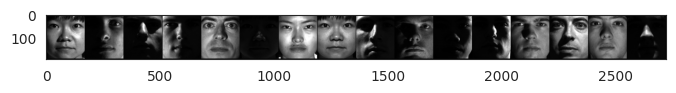

The predictions:
 {tensor([[ 4, 16, 24, 18,  5,  4, 25,  4, 27, 28, 35, 24, 18,  5, 22, 14]],
       device='cuda:0')}
Accuracy of the network on the 16 test images: 93.75 %


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images/255, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the {batch_size} test images: {100 * correct_rate} %')

### 問題與討論 : 
    在這個batch中雖然有著93.75%的準確率，但我們不夠滿意。

# 模型建立2

* 由於前面提到的過擬合問題，我們另外加入dropout層嘗試減緩過擬合，另外我們也設置zero padding，希望能夠改善訓練結果。

In [10]:
class NetDropout(nn.Module):
 
    def __init__(self):
        super(NetDropout, self).__init__()
         
        self.conv1 = nn.Conv2d(in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2)
        self.conv2 = nn.Conv2d(16, 32, 5, 1, 2)
 
        self.fc1 = nn.Linear(32 * 48 * 42, 120)  # conv windows: 32  X  image dimension: 48 * 42
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 38) # 38 output classes
        self.dropout = nn.Dropout(p = 0.5) # 0.5 dropout probability
 
    def forward(self, x):
        # (192, 168)
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2)) 
        # conv: (192, 168) -> pool: (96, 84)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        # conv: (96, 84) -> pool: (48, 42)
        x = torch.flatten(x, 1)
        x = F.relu(self.dropout(self.fc1(x)))
        x = F.relu(self.dropout(self.fc2(x)))
        x = self.fc3(x)
        return x
    
netdrop = NetDropout().to(device)
print(netdrop)

out = netdrop(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())

NetDropout(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (fc1): Linear(in_features=64512, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=38, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
(1, 38)
tensor([[ 2.4013, -1.0498,  0.4000,  1.6039,  0.9293, -2.4833, -2.2169,  0.2941,
         -3.1943, -2.5804,  4.6222,  0.1600, -2.4378, -0.3583, -0.6921,  2.4713,
         -1.5502, -1.8644,  3.2432, -1.9933, -0.1349,  2.4312, -2.1437, -1.9851,
          5.8265, -3.5206, -4.3983, -4.8984, -1.7345,  2.2832, -0.3623, -1.6739,
         -1.7608, -0.4396, -0.3043, -7.3719, -2.0480, -5.1889]],
       device='cuda:0')
tensor([[24]], device='cuda:0')
[[ 2.4013128  -1.0497814   0.39996874  1.603872    0.92934436 -2.4833155
  -2.2169366   0.29411522 -3.1942778  -2.5803528   4.6221623   0.16004147
  -2.

### 問題與討論 : 
    可以看到網路結構應該是沒有問題的。

* 接著我們開始訓練

In [ ]:
epochs = 100
model = netdrop

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainLoss = []
trainAcc = []
validLoss = []
validAcc = []
for epoch in tqdm(range(epochs), position=0, file=sys.stdout, desc="desc") :

    running_loss = train(model, train_loader)

    trEpoch = getLossAcc(model, train_loader)
    vaEpoch = getLossAcc(model, valid_loader)

    trainAcc.append(trEpoch[0])
    trainLoss.append(trEpoch[1])
    validAcc.append(vaEpoch[0])
    validLoss.append(vaEpoch[1])

    if epoch%10 == 9 or epoch == 0 :
      tqdm.write(f'[epoch : {epoch + 1}] loss: {running_loss / 200:.8f} acc: {trEpoch[0]:.4f} valid_acc: {vaEpoch[0]:.4f}')

print('Finished Training')  

[epoch : 1] loss: 0.00120027 acc: 0.1032 valid_acc: 0.1500
[epoch : 10] loss: 0.00017108 acc: 0.9974 valid_acc: 0.9500
[epoch : 20] loss: 0.00009432 acc: 0.9984 valid_acc: 0.9500
[epoch : 30] loss: 0.00006243 acc: 0.9984 valid_acc: 0.9500
[epoch : 40] loss: 0.00007201 acc: 0.9979 valid_acc: 0.9500
[epoch : 50] loss: 0.00005365 acc: 0.9984 valid_acc: 0.9500
[epoch : 60] loss: 0.00003614 acc: 0.9979 valid_acc: 0.9500
[epoch : 70] loss: 0.00003381 acc: 0.9990 valid_acc: 1.0000
[epoch : 80] loss: 0.00002075 acc: 0.9995 valid_acc: 1.0000
[epoch : 90] loss: 0.00002412 acc: 0.9995 valid_acc: 1.0000
[epoch : 100] loss: 0.00002489 acc: 1.0000 valid_acc: 1.0000
desc: 100%|██████████| 100/100 [02:09<00:00,  1.29s/it]
Finished Training


### 問題與討論 : 
    更換了網路結構後，我們可以看到訓練過程不但Loss收斂得很快，驗證集的準確率也都有穩定上升，甚至穩定在100%，是很理想的結果。

* 損失函數以及準確率圖

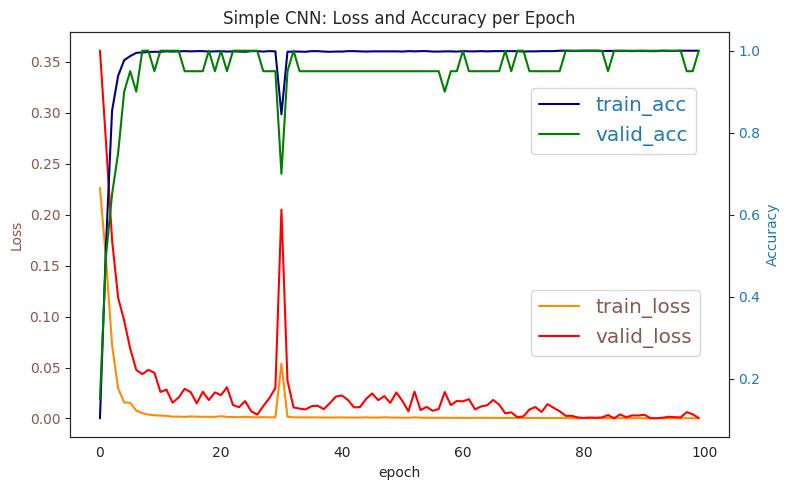

In [ ]:
drawPlot('Simple CNN', trainLoss, validLoss, trainAcc, validAcc)

### 問題與討論 : 
    可以看到雖然在50個epochs前有較大的波動，但之後就開始慢慢穩定下來了，很理想的結果。

* 測試集表現

In [ ]:
print(f'Accuracy and Loss of the Net\nAcc: {100 * getLossAcc(model, test_loader)[0]:.4f} %\nLoss: {getLossAcc(model, test_loader)[1]:.6f}')

Accuracy and Loss of the Net
Acc: 100.0000 %
Loss: 0.000098


### 問題與討論 : 
    測試集的準確率來到了100%，在其他網路結構變動不大的情況下，可以說dropout層確實起到了很大的作用，很好的防止了過擬合並得到了更好的訓練成果，由於準確率達到了100%，這裡就不再多放部分測試的觀察了。

* 模型存檔: 我們將模型存為dropoutNET.pt並存下來。

In [22]:
PATH = dirThis + 'dropoutNET.pt'
torch.save(model.state_dict(), PATH)

* 模型讀取: 我們將剛剛存好的模型讀入測試是否正常。

In [24]:
model = NetDropout().to(device)
model.load_state_dict(torch.load(dirThis + 'dropoutNET.pt'))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
print(f'Accuracy and Loss of the Net\nAcc: {100 * getLossAcc(model, test_loader)[0]:.4f} %\nLoss: {getLossAcc(model, test_loader)[1]:.6f}')

Accuracy and Loss of the Net
Acc: 100.0000 %
Loss: 0.000115


### 問題與討論 : 
    讀取模型沒有問題，功能一切正常。

# Bonus: AlexNet

* 因為好奇想知道AlexNet這個把CNN帶向世界的結構能有怎樣的表現，所以我實作了一個AlexNet，並觀察他在這筆Yale Face Data上的表現。

In [27]:
class AlexNet(nn.Module) :
    def __init__(self) :
        super(AlexNet, self).__init__()
        self.myModel()
    
    def myModel(self) :
        self.conv1 = nn.Sequential(nn.Conv2d(1, 96, (11, 11), stride = 4, padding = 2),
                                   nn.ReLU(inplace = True),
                                   nn.MaxPool2d((3, 3), stride = 2)
                                   )
        
        self.conv2 = nn.Sequential(nn.Conv2d(96, 256, (5, 5), stride = 1, padding = 2),
                                   nn.ReLU(inplace = True),
                                   nn.MaxPool2d((3, 3), stride = 2)
                                   )
        
        self.conv3 = nn.Sequential(nn.Conv2d(256, 384, (3, 3), stride = 1, padding = 1),
                                   nn.ReLU(inplace = True)
                                   )
        
        self.conv4 = nn.Sequential(nn.Conv2d(384, 384, (3, 3), stride = 1, padding = 1),
                                   nn.ReLU(inplace = True)
                                   )
        
        self.conv5 = nn.Sequential(nn.Conv2d(384, 256, (3, 3), stride = 1, padding = 1),
                                   nn.ReLU(inplace = True),
                                   nn.MaxPool2d((3, 3), stride = 2)
                                   )
        
        # conv windows: 256  X  image dimension: 4 * 5
        self.fc1 = nn.Sequential(nn.Linear(256 * 4 * 5, 4096), nn.Dropout(p = 0.6)) 
        self.fc2 = nn.Sequential(nn.Linear(4096, 38))

    def forward(self, x) :
        # (192, 168)
        x = self.conv1(x)
        # conv: (41, 47) -> pool: (20, 23)
        x = self.conv2(x)
        # conv: (19, 23) -> pool: (9, 11)
        x = self.conv3(x)
        # conv: (9, 11)
        x = self.conv4(x)
        # conv: (9, 11)
        x = self.conv5(x)
        # conv: (9, 11) -> pool: (4, 5)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.fc2(x)

        return x
    
alexnet = AlexNet().to(device)
print(alexnet)

out = alexnet(input.to(device))
print(out.to("cpu").detach().numpy().shape)
print(out.data)
print(out.data.max(1, keepdim=True)[1])
print(out.to("cpu").detach().numpy())

AlexNet(
  (conv1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
  )
  (conv5): Sequential(
    (0): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=5120, out_feature

### 問題與討論 : 
    可以看到雖然結構比較複雜，但應該是沒有問題可以正常運作的。

* 接著我們開始訓練

In [ ]:
epochs = 100
model = AlexNet(38).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

trainLoss = []
trainAcc = []
validLoss = []
validAcc = []
for epoch in tqdm(range(epochs), position=0, file=sys.stdout, desc="desc") :

    running_loss = train(model, train_loader)

    trEpoch = getLossAcc(model, train_loader)
    vaEpoch = getLossAcc(model, valid_loader)

    trainAcc.append(trEpoch[0])
    trainLoss.append(trEpoch[1])
    validAcc.append(vaEpoch[0])
    validLoss.append(vaEpoch[1])

    if epoch%10 == 9 or epoch == 0 :
      tqdm.write(f'[epoch : {epoch + 1}] loss: {running_loss / 200:.8f} acc: {trEpoch[0]:.4f} valid_acc: {vaEpoch[0]:.4f}')

print('Finished Training')

[epoch : 1] loss: 0.00115659 acc: 0.0299 valid_acc: 0.0500
[epoch : 10] loss: 0.00010528 acc: 0.9644 valid_acc: 0.7500
[epoch : 20] loss: 0.00001913 acc: 0.9927 valid_acc: 0.9000
[epoch : 30] loss: 0.00000533 acc: 0.9990 valid_acc: 0.9500
[epoch : 40] loss: 0.00001177 acc: 0.9979 valid_acc: 0.9000
[epoch : 50] loss: 0.00004915 acc: 0.9963 valid_acc: 0.8500
[epoch : 60] loss: 0.00009687 acc: 0.9906 valid_acc: 0.9000
[epoch : 70] loss: 0.00000532 acc: 0.9984 valid_acc: 0.9000
[epoch : 80] loss: 0.00000205 acc: 0.9990 valid_acc: 0.9000
[epoch : 90] loss: 0.00004154 acc: 0.9764 valid_acc: 0.8500
[epoch : 100] loss: 0.00000284 acc: 0.9990 valid_acc: 0.9000
desc: 100%|██████████| 100/100 [02:05<00:00,  1.26s/it]
Finished Training


### 問題與討論 : 
    可以看到AlexNet的訓練雖然有著不錯的效果，但驗證集的反應其實沒有非常理想。

* 損失函數以及準確率圖

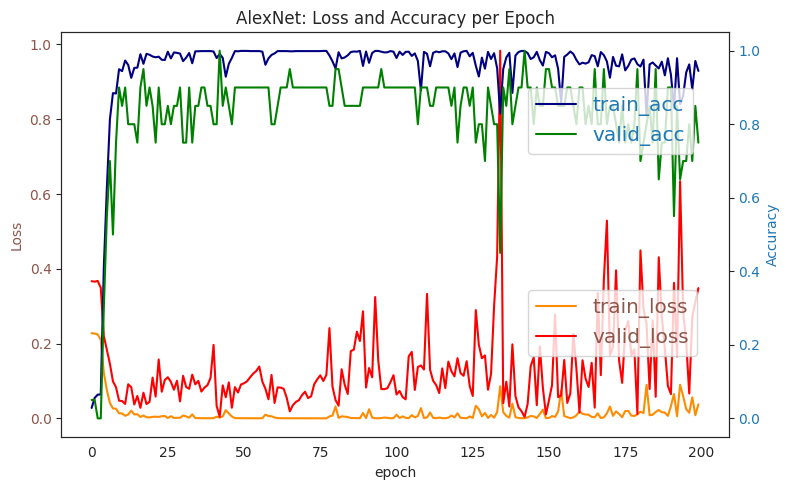

In [ ]:
drawPlot('AlexNet', trainLoss, validLoss, trainAcc, validAcc)

### 問題與討論 : 
    從這張圖我們就可以很明顯的看出AlexNet應用在這筆資料上的問題，拿這樣比較深的結構來訓練Yale Face Data這樣相對於深度學習不大的資料集，即使有著dropout層防止過擬合，驗證集隨著訓練深度加深而表現不好仍然無可避免。

* 測試集表現

In [ ]:
print(f'Accuracy and Loss of the Net\nAcc: {100 * getLossAcc(model, test_loader)[0]:.4f} %\nLoss: {getLossAcc(model, test_loader)[1]:.6f}')

Accuracy and Loss of the Net
Acc: 97.0954 %
Loss: 0.009975


### 問題與討論 : 
    測試集的準確率有97.09%，雖然已經是很不錯的數字，但是相對於上面簡單加上dropout的CNN所得到的100%仍有差距。

* 觀察部分測試的實際情況

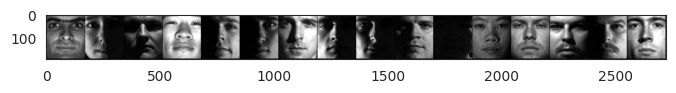

The predictions:
 {tensor([[10, 32,  6, 12, 17, 31,  9, 15, 21,  3,  4, 35,  0, 19, 19, 27]],
       device='cuda:0')}
Accuracy of the network on the 16 test images: 100.0 %


In [ ]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np
 
sample_idx = torch.randint(len(test_loader), size=(1,)).item()
dataiter = iter(test_loader)
for i in range(sample_idx): # randomly select a batch
    images, labels = next(dataiter)
 
# print test images
nrow = 16 # number of images per row
montage = torchvision.utils.make_grid(images/255, nrow=nrow)
plt.imshow(np.transpose(montage, (1, 2, 0)), cmap='gray')
plt.show()
 
# predict the labels
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)
print("The predictions:\n", {predicted.reshape(batch_size // nrow, nrow)})
 
total = labels.size(0)
correct_rate = (predicted == labels.to(device)).sum().item() / total
print(f'Accuracy of the network on the {batch_size} test images: {100 * correct_rate} %')

### 問題與討論 : 
    在這個batch中有100%的準確率，這個模型畢竟還是有97%的準確率，表現還是不錯的。

# 結論

由上面建構的三個CNN我們可以知道，CNN的結構是會大大影響對資料的解釋能力的，而且模型深度也不是越深越好，像是AlexNet這樣比較複雜的結構在這個資料集上反而討不到便宜；當然結構也不能太簡單，像最一開始的模型就被過擬合所限制。這次的作業讓我學到建構網路時其實不是越深越好，也不是訓練次數疊的越多越好，配合驗證集觀察訓練情況，並視當下情況調整訓練方法或是檢查資料及模型是否有結構上的問題，以此多次調整後才能找到最適合這個資料的模型。
例如在這筆Yale Face Data中，透過上面的觀察我才得以成功找出最適合這筆資料的模型以及資料型態，也才成功達到了100%的準確率。

### 最後我們用前面訓練出的最好的模型來隨機判斷一張圖片的Label作為結束。

#### 首先我們讀取模型

In [28]:
model = NetDropout()
model.load_state_dict(torch.load(dirThis + 'dropoutNET.pt'))

<All keys matched successfully>

#### 接著我們選一張圖片並印出

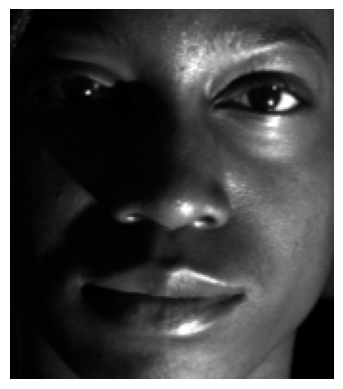

The face was labeled 20


In [29]:
dataiter = iter(test_loader) 
images, labels = next(dataiter)

labelOfTry = labels[0].to('cpu').detach().numpy()

Take = images[0]
Try = np.transpose(Take, (1, 2, 0))
plt.imshow(Try, cmap='gray')
plt.axis('off')
plt.show()
print(f"The face was labeled {labelOfTry}")

* 我們可以看到這張圖片的Label是20，接著我們用上面讀取的model來判斷這張圖片的Label。

In [46]:
model.eval()

with torch.no_grad():
    k = Take.shape
    outputs = model(Take.reshape(1, k[0], k[1], k[2]))
    
    _, predicted = torch.max(outputs.data, 1)
    print(f"The face has REAL LABEL: {labelOfTry} and PREDICTED LABEL: {predicted.to('cpu').detach().numpy()[0]}.\n")

The face has REAL LABEL: 20 and PREDICTED LABEL: 20.



可以看到我們的模型成功預測了這張圖片的Label。

* 我們將其封裝成函式

Input a face labeled 32


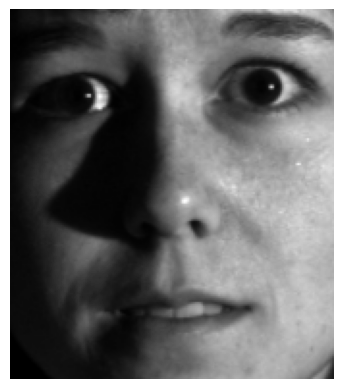

The face has REAL LABEL: 32 and PREDICTED LABEL: 32.



In [47]:
def predOneFace(model, torchFace, torchLabel) :
    labelOfTry = torchLabel.to('cpu').detach().numpy()

    Try = np.transpose(torchFace, (1, 2, 0))
    print(f"Input a face labeled {labelOfTry}")
    plt.imshow(Try, cmap='gray')
    plt.axis('off')
    plt.show()

    model.eval()

    with torch.no_grad():
        k = torchFace.shape
        outputs = model(torchFace.reshape(1, k[0], k[1], k[2]))
        
        _, predicted = torch.max(outputs.data, 1)
        print(f"The face has REAL LABEL: {labelOfTry} and PREDICTED LABEL: {predicted.to('cpu').detach().numpy()[0]}.\n")

predOneFace(model, images[1], labels[1])

如此我們可以任意輸入一張測試影像並輸出所辨識人臉的Label。